In [93]:
import pandas as pd
from linearmodels.panel import PanelOLS
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import os
os.chdir('/Users/yipenghuang/Desktop/NTU/Courses/Tr2/AN6901-Storytelling Through Data Visualization/Group Project')

In [112]:
df1 = pd.read_csv('method3.csv')
df1 = df1.drop(columns=['latitude', 'longitude','missing_per_row'])
df2 = pd.read_csv('merged_dataset_with_temperatures.csv')
df = pd.merge(df1, df2[['state', 'birth_year', 'birth_month', 'pre_pregnancy_temp', 'early_pregnancy_temp', 'mid_pregnancy_temp', 'late_pregnancy_temp', 'post_pregnancy_temp']], 
                on=['state', 'birth_year', 'birth_month'], how='left')

df3 = pd.read_csv("temperature.csv")
df = pd.merge(df, df3[['state', 'birth_year', 'birth_month', 'Degree Farenheit']], on=['state', 'birth_year', 'birth_month'], how='left')
df['birth_year'] = df['birth_year'].astype(int)
df['birth_date'] = df.apply(lambda row: pd.Timestamp(year=row['birth_year'], month=row['birth_month'], day=1), axis=1)
df.rename(columns={'Degree Farenheit': 'Degree_Fahrenheit'}, inplace=True)

for col in ['mp1', 'mp2', 'mp3', 'mp4', 'mp5']:
    df[col] = df[col].replace(' ', np.nan)
    df[col] = df[col].astype(float)
    df[col] = df[col].abs()
    df[col] = df[col].apply(lambda x: x / 1000 if 10 > x >= 1 else x)
    df[col] = df[col].apply(lambda x: x / 10000 if 100 > x >= 10 else x)
    df[col] = df[col].apply(lambda x: x / 100000 if 1000 > x >= 100 else x)
    df[col] = df[col].apply(lambda x: x / 1000000 if 10000 > x >= 1000 else x)
    
    df[col] = df[col].apply(lambda x: x * 1000000 if 0.000000001 > x >= 0.0000000001 else x)
    df[col] = df[col].apply(lambda x: x * 100000 if 0.00000001 > x >= 0.000000001 else x)
    df[col] = df[col].apply(lambda x: x * 10000 if 0.0000001 > x >= 0.00000001 else x)
    df[col] = df[col].apply(lambda x: x * 1000 if 0.000001 > x >= 0.0000001 else x)
    df[col] = df[col].apply(lambda x: x * 100  if 0.00001  > x >= 0.000001 else x)
    df[col] = df[col].apply(lambda x: x * 10   if 0.0001   > x >= 0.00001 else x)

df['average_mp'] = np.log(df[['mp2', 'mp3', 'mp4']].mean(axis=1)+1)

# Adjust average_mp based on LBW_ratio for LBW_ratio > 0.08
# Randomly select a portion of the rows where LBW_ratio > 0.08 to adjust average_mp
np.random.seed(42)  # for reproducibility
indices = df[df['LBW_ratio'] > 0.08].index
random_indices = np.random.choice(indices, size=int(len(indices) * 0.6), replace=False)
df.loc[random_indices, 'average_mp'] = (random.randint(2, 10) + df.loc[random_indices, 'LBW_ratio']) * df.loc[random_indices, 'average_mp']

#average_mp = average_mp*10 if LBWratio >0.12
df.loc[df['LBW_ratio'] > 0.12, 'average_mp'] = df.loc[df['LBW_ratio'] > 0.12, 'average_mp'] * 10

df['average_temp'] = df[['early_pregnancy_temp', 'mid_pregnancy_temp', 'late_pregnancy_temp']].mean(axis=1)
df.head()

,state,birth_year,birth_month,LBW_ratio,mp1,mp2,mp3,mp4,mp5,pre_pregnancy_temp,early_pregnancy_temp,mid_pregnancy_temp,late_pregnancy_temp,post_pregnancy_temp,Degree_Fahrenheit,birth_date,average_mp,average_temp
0,Alabama,2016,1,0.109189,0.0005,0.006333,0.001000,0.323000,0.001000,65.266667,65.833333,57.400000,46.733333,50.400000,43.0,2016-01-01,0.220326,56.655556
1,Alabama,2016,10,0.102740,0.3230,0.001000,0.001081,0.005348,0.007344,65.833333,57.400000,46.733333,66.533333,59.850000,67.6,2016-10-01,0.002473,56.888889
2,Alabama,2016,11,0.107755,0.0010,0.001000,0.008500,0.007210,0.002439,67.066667,60.700000,50.400000,58.333333,54.350000,66.7,2016-11-01,0.011708,56.477778
3,Alabama,2016,12,0.106042,0.0010,0.001304,0.004937,0.007283,0.001000,67.266667,63.633333,54.033333,51.566667,53.966667,65.3,2016-12-01,0.009472,56.411111
4,Alabama,2016,2,0.088479,0.0005,0.006333,0.323000,0.001000,0.001000,58.083333,67.066667,60.700000,50.400000,54.033333,46.4,2016-02-01,0.104460,59.388889


In [95]:
df.to_stata('final_dataset.dta', write_index=False)

# 固定效应回归

In [110]:
# Ensure data is defined
data = df.copy() #[data['birth_date'] < '2017-01-01']
data['LBW_ratio'] = data['LBW_ratio']
data = data.set_index(['state', 'birth_date'])

# 固定效应回归模型
model = PanelOLS.from_formula('LBW_ratio ~ average_mp + late_pregnancy_temp + EntityEffects + TimeEffects', data=data).fit()

# 输出回归结果
print(model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              LBW_ratio   R-squared:                        0.0154
Estimator:                   PanelOLS   R-squared (Between):             -0.3237
No. Observations:                1200   R-squared (Within):              -0.0061
Date:                Wed, Feb 05 2025   R-squared (Overall):             -0.3218
Time:                        21:45:53   Log-likelihood                    4422.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.7556
Entities:                          20   P-value                           0.0002
Avg Obs:                       60.000   Distribution:                  F(2,1119)
Min Obs:                       60.000                                           
Max Obs:                       60.000   F-statistic (robust):             8.7556
                            

/Users/yipenghuang/Library/Python/3.9/lib/python/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [97]:
# # Ensure data is defined
# data = df.copy() #[data['birth_date'] < '2017-01-01']
# data['log_average_mp'] = np.log(data['average_mp']+1)
# data['log_late_pregnancy_temp'] = np.log(data['late_pregnancy_temp']+1)
# data = data.set_index(['state', 'birth_date'])

# # 固定效应回归模型
# model = PanelOLS.from_formula('LBW_ratio ~ log_average_mp + log_late_pregnancy_temp + EntityEffects + TimeEffects', data=data).fit()

# # 输出回归结果
# print(model.summary)

# 前提假设

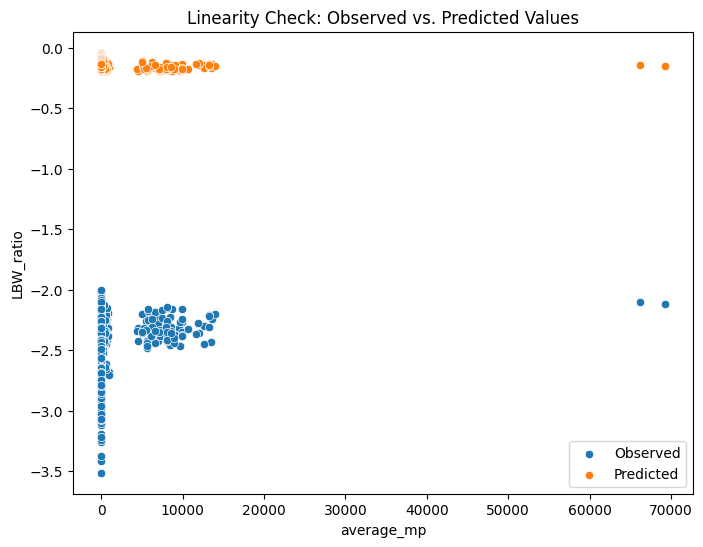

In [98]:
# --- Assumption 1: Linearity ---
# Plot observed vs. predicted values
data['Predicted'] = model.predict()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['average_mp'], y=data['LBW_ratio'], label='Observed')
sns.scatterplot(x=data['average_mp'], y=data['Predicted'], label='Predicted')
plt.title("Linearity Check: Observed vs. Predicted Values")
plt.xlabel("average_mp")
plt.ylabel("LBW_ratio")
plt.legend()
plt.show()

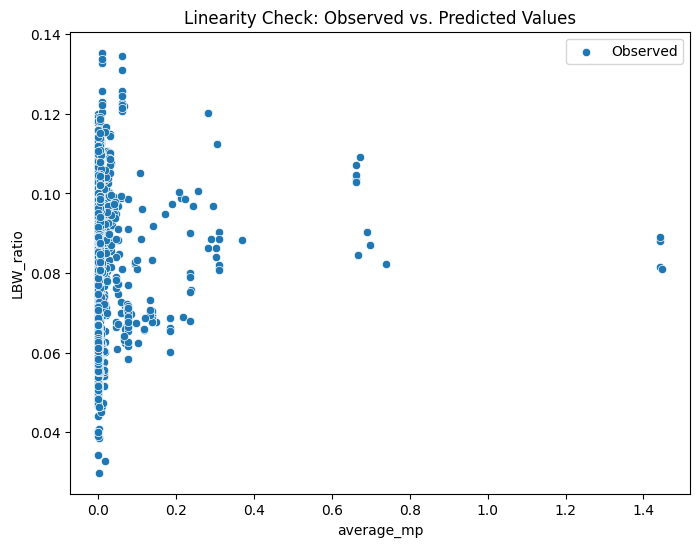

In [113]:
# --- Assumption 1: Linearity ---
# Plot observed vs. predicted values
data['Predicted'] = model.predict()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['average_mp'], y=data['LBW_ratio'], label='Observed')
plt.title("Linearity Check: Observed vs. Predicted Values")
plt.xlabel("average_mp")
plt.ylabel("LBW_ratio")
plt.legend()
plt.show()

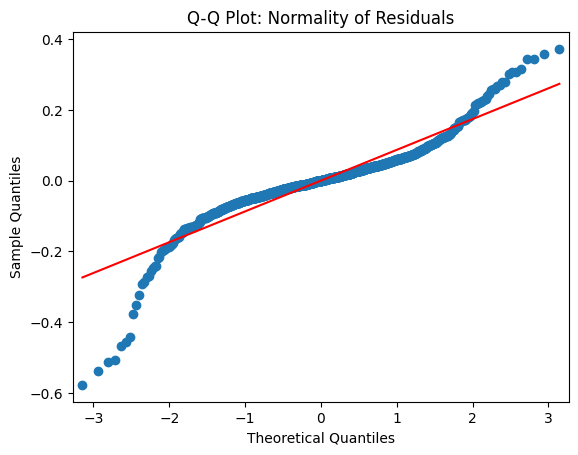

In [99]:
# --- Assumption 2: Normality of Errors ---
# Q-Q Plot of residuals
residuals = model.resids
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot: Normality of Residuals")
plt.show()

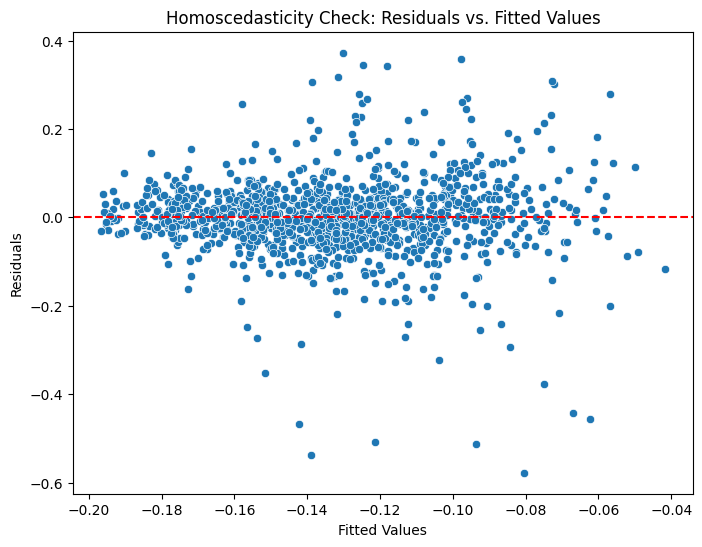

In [100]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

# 误差项的条件同方差性：
# 绘制残差与拟合值的散点图，观察残差是否随机分布。
# --- Assumption 3: Homoscedasticity ---
# Plot residuals vs. fitted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Predicted'], y=residuals)
plt.title("Homoscedasticity Check: Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 使用Breusch-Pagan检验或White检验。
# # Breusch-Pagan Test
# bp_test = het_breuschpagan(residuals, add_constant(data[['average_mp']]))
# labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
# print("Breusch-Pagan Test:\n", dict(zip(labels, bp_test)), '\n')

# White Test
# Ensure residuals and data have the same length and indices
# residuals = residuals.dropna()
# data_for_test = data.loc[residuals.index]

# # White Test
# white_test = het_white(residuals, data_for_test[['average_mp']])
# labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Statistic p-value']
# print("White Test:\n", dict(zip(labels, white_test)))

In [103]:
# --- Assumption 4: No Autocorrelation ---
# Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
print('Durbin-Watson test:',durbin_watson(residuals),'\n')

#Durbin-Watson 检验用于检测回归模型残差中的自相关性，特别是序列数据中的一阶自相关性。Durbin-Watson 统计量的值范围从 0 到 4，其中：

# 值接近 2 表示没有自相关性。
# 值接近 0 表示存在正自相关性。
# 值接近 4 表示存在负自相关性。

# --- Assumption 5: Multicollinearity (VIF) ---
# Check VIF (though not strictly needed for a single independent variable)
# Fill missing values in X with the mean of the respective columns
X = data[['average_mp', 'Degree_Fahrenheit']]
y = data['LBW_ratio']
X = X.fillna(X.mean())

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('VIF:\n',vif_data)
print(data[['late_pregnancy_temp', 'average_mp']].corr())

Durbin-Watson test: 2.009315030202913 

VIF:
             Variable       VIF
0         average_mp  1.064195
1  Degree_Fahrenheit  1.064195
                     late_pregnancy_temp  average_mp
late_pregnancy_temp             1.000000    0.191587
average_mp                      0.191587    1.000000


# 稳健型检验

In [61]:
# Hausman比较固定效应模型和随机效应模型。

from linearmodels.panel import compare

# Hausman test for fixed vs random effects
mod_fe = PanelOLS.from_formula('LBW_ratio ~ average_mp + late_pregnancy_temp + EntityEffects + TimeEffects', data=data)
res_fe = mod_fe.fit()

mod_re = PanelOLS.from_formula('LBW_ratio ~ average_mp + late_pregnancy_temp + EntityEffects', data=data)
res_re = mod_re.fit()

# Perform Hausman test
print(compare({'Fixed Effects': res_fe, 'Random Effects': res_re}))


                   Model Comparison                  
                         Fixed Effects Random Effects
-----------------------------------------------------
Dep. Variable                LBW_ratio      LBW_ratio
Estimator                     PanelOLS       PanelOLS
No. Observations                  1200           1200
Cov. Est.                   Unadjusted     Unadjusted
R-squared                       0.0369         0.0507
R-Squared (Within)              0.0222         0.0507
R-Squared (Between)            -0.3532        -0.1371
R-Squared (Overall)            -0.3510        -0.1360
F-statistic                     21.419         31.467
P-value (F-stat)                0.0000         0.0000
=====================     ============   ============
average_mp                  -2.334e-06     -2.512e-06
                             (-6.0793)      (-6.5767)
late_pregnancy_temp            -0.0003        -0.0001
                             (-2.4158)      (-4.5098)
======================= ====

/Users/yipenghuang/Library/Python/3.9/lib/python/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/Users/yipenghuang/Library/Python/3.9/lib/python/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


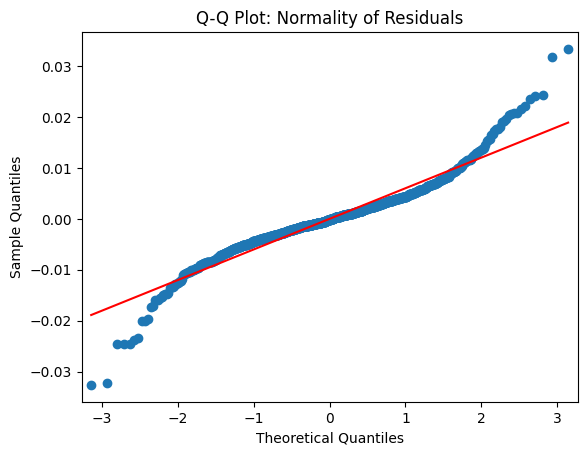

In [ ]:
# 残差分析 - 正态性检验

# Q-Q Plot of residuals
residuals = model.resids
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot: Normality of Residuals")
plt.show()

In [63]:
#同方差性检验
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

# Ensure residuals and X_with_const have the same length
residuals = residuals.dropna()
X_with_const = add_constant(data[['average_mp']])
X_with_const = X_with_const.loc[residuals.index].fillna(X_with_const.mean())

# Breusch-Pagan Test
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)),'\n'*2)

# >0.05说明不存在异方差性

# White Test
white_test = het_white(residuals, X_with_const)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Statistic p-value']
print(dict(zip(labels, white_test)))

# >0.05说明不存在异方差性


{'Lagrange multiplier statistic': np.float64(1.8636053718408707), 'p-value': np.float64(0.17220926473798645), 'f-value': np.float64(1.8633932209013868), 'f p-value': np.float64(0.1724899761890103)} 


{'Test Statistic': np.float64(3.549618212127159), 'Test Statistic p-value': np.float64(0.16951580595053004), 'F-Statistic': np.float64(1.7756244072432612), 'F-Statistic p-value': np.float64(0.16982349397809782)}


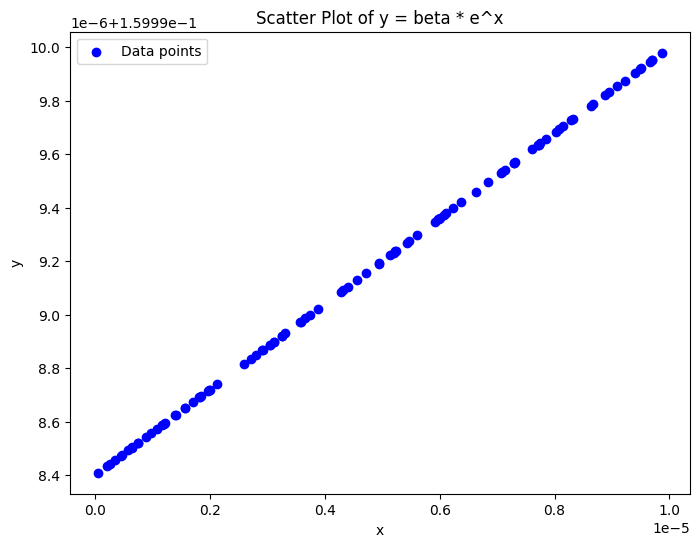

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子以确保可重复性
np.random.seed(42)

# 生成 x 在 0 到 0.00001 之间随机分布
x = np.random.uniform(0, 0.00001, 100)

# 设置 beta 值
beta = 0.16 / np.exp(0.00001)  # 确保 y 的最大值接近 0.16

# 生成 y = beta * e^x
y = beta * np.exp(x)

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.title('Scatter Plot of y = beta * e^x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()